<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 3 </h1> 
    <h2> Random Forests </h2>
</div>    

# Overview


This tutorial is based on work done by Chetan Deva on Using random forest to predectict leaf temperature from a numer of measurable featutes. 

Plants regulate temp in extreme environment. e.g. a plant in a desert can stay 18C cool than air temp or 22 C warmer than air in mountains Leaf temperature differs from air temperature. Plant growth and development is strongly dependent on leaf temperature. Most Land Surface Models (LSMs) & Crop growth models (CGMs) use air temperature as an approximation of leaf temperature. 

However, during time periods when large differences exist, this can be an important source of input data uncertainty.

In this tutorial leaf data containing a number of featuers is fed into a random forest regression model to evaluate which features are the most important to accutately predict the leaf temperature differential   

* [Leaf temp](https://esajournals.onlinelibrary.wiley.com/doi/pdf/10.1002/ecs2.2768)

<div style="background-color: #e6ccff; padding: 10px;">


<h1>Random Forests </h1>

    
Random forests are ensembles of decision trees where each decision tree produces a prediction and an average is taken, in this tutorial we will first build a simple decision tree and then build on that use python libraries to easily create Random Forest models to investigate what features are important in determing leaf temperature 
    
## Recommended reading 
* [RandomForests overview paper](https://link.springer.com/article/10.1023/A:1010933404324)
* [Random Forest overview linked with python](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76)

</div>


<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

Basic python knowledge is assumed for this tutorial and this tutoria will use [SciKit-Learn](https://scikit-learn.org/stable/) which covers a wide variety of useful machine learning tools. All the following code should run quickly on a standard laptop.
    
</div>
    
<hr>

<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* scikit-learn
* notebook
* numpy
* seaborn
* matplotlib
* pandas
* statistics


<h2> Data Requirements</h2>
    
This notebook referes to some data included in the git hub repositroy
    
</div>


**Contents:**


1. [Leaf Data](#Leaf-Data)
2. [Decision Trees](#Decision-Trees)
3. [Random Forests](#Random-Forests)
4. [Hyper Parameters](#HyperParameters)
5. [Using Automated Hyperparamter Selection](#Using-Automated-Hyperparamter-Selection)) 


<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (includig some auxillary code) and turn off warnings. Make sure Keras session is clear
</div>

In [10]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
import numpy as np
import pandas as pd
import statistics
import itertools
from subprocess import call
from IPython.display import Image
# plotting libraries
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# sklearn libraries
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix


# Leaf Data

<div style="background-color: #ccffcc; padding: 10px;">
 

805 observations of bean leaves were taken over 3 separate growing seasons with adequate water and nitrogen (e.g. good conditions). 
    
<img src="images/leaf_engery_balance.png">
    
The leaf energy balance depends on shortwave radiation in ($Sw_{in}$),  Net longwave ($Lw_{in}$ vs. $Lw_{out}$)  and the cooling effects of leaf transpiration ($LE$)


This is used to select features used (shown in the table below)
    
| Feature    | Description |
| -----------|---------- |
| Air temperature  | 2 cm above the leaf  |
| Leaf temperature | Using a contactless infrared camera  |
| Relative Humidity  | Relative Humidity next to the leaf  |
| Photosynthetically active radiation | The part of the spectrum the plant uses |
| Photosynthetic Efficiency | % of incoming light going to photochemistry |
| Proton conductivity  |  Steady state rate of proton flux across membrane |
| Relative Chlorophyll  | Greenness of the leaf |
| Leaf Thickness | Greenness of the leaf |
| Leaf Angle | The leaf angle |

    

In [263]:
#%% import the data 
df = pd.read_csv('data/df_prepped.csv')

In [283]:
print('There are '+ str(len(df)) + ' data entries\n')
print('Min Ambient Temperature is ' + str(df['Ambient Temperature'].values.min())+'\n')
print('Max Ambient Temperature is ' + str(df['Ambient Temperature'].values.max())+'\n')
print('Std Ambient Temperature is ' + str(df['Ambient Temperature'].values.std())+'\n')
print('Min Ambient Humidity is ' + str(df['Ambient Humidity'].values.min())+'\n')
print('Max Ambient Humidity is ' + str(df['Ambient Humidity'].values.max())+'\n')
print('Std Ambient Humidity is ' + str(df['Ambient Humidity'].values.std())+'\n')
print('Min Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.min())+'\n')
print('Max Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.max())+'\n')
print('Mean Leaf Temperature Differential is ' + str(df['Leaf Temperature Differential'].values.mean())+'\n')


There are 805 data entries

Min Ambient Temperature is 23.4

Max Ambient Temperature is 41.97

Std Ambient Temperature is 3.2823937955594182

Min Ambient Humidity is 34.719

Max Ambient Humidity is 76.646

Std Ambient Humidity is 9.00589183215784

Min Leaf Temperature Differential is -10.97

Max Leaf Temperature Differential is 6.66

Mean Leaf Temperature Differential is -4.285552795031056



<div style="background-color: #ccffcc; padding: 10px;">

## Summary of weather conditions in the data

The data is in a fairly narrow range of temperature and relative humidity, but these ranges are typical for this crop breeding station.


## Leaf Temperature Differential 

The mean difference between leaf and air temperature is about -4 (°C) meaning the leaves are often cooler than the air .
    

</div>

In [14]:
#%% calculate required variables 

# leaf temperature 
df['ltemp'] = df['Ambient Temperature'] + df['Leaf Temperature Differential']

#%% define the target variable and the predictors

# define the variable for prediction
y = df['ltemp']

# define the dataframe of predictor variables 
X = df.drop(['ltemp', 'Leaf Temperature Differential'], axis = 1)

# create list of random numbers 
rnumbers = list(np.random.randint(1,1000, size=X.shape[0]))

# create dataframe for feature selection purposes only including a column of random numbers
X_features = X
X_features['random_numbers'] = rnumbers

<div style="background-color: #ccffcc; padding: 10px;">
    

# Decision Tree Simple Example

First, we create the features `X_2f` from a subset of our data and the labels `yy`. There are only two features, which will allow us to visualize the data and which makes this a very easy problem.
    
</div>

In [68]:
# Set random seed to ensure "reproducible" runs
RSEED = 50
# X_2f
X_1f = np.zeros((805,2))
X_1f[:,0] = np.array(X['Ambient Temperature'])
X_1f[:,1] = np.array(X['Ambient Humidity'])
N=800
X_1f=X_1f[0:N,:]
# label classes for simplicty split into two classes low or high
yy=pd.DataFrame()
yy['vals']=y[0:N]
yy['label']=pd.qcut(yy.vals.values, 2, labels=[0, 1])
yy['strlabel']=''
yy.strlabel[yy.label==1]='high'
yy.strlabel[yy.label==0]='low'

<div style="background-color: #ccffcc; padding: 10px;">
    
## Data Visualization

To get a sense of the data, we can graph some of the data points with the number showing the label.
    
</div>

Text(0.5, 1.0, 'Leaf Temp')

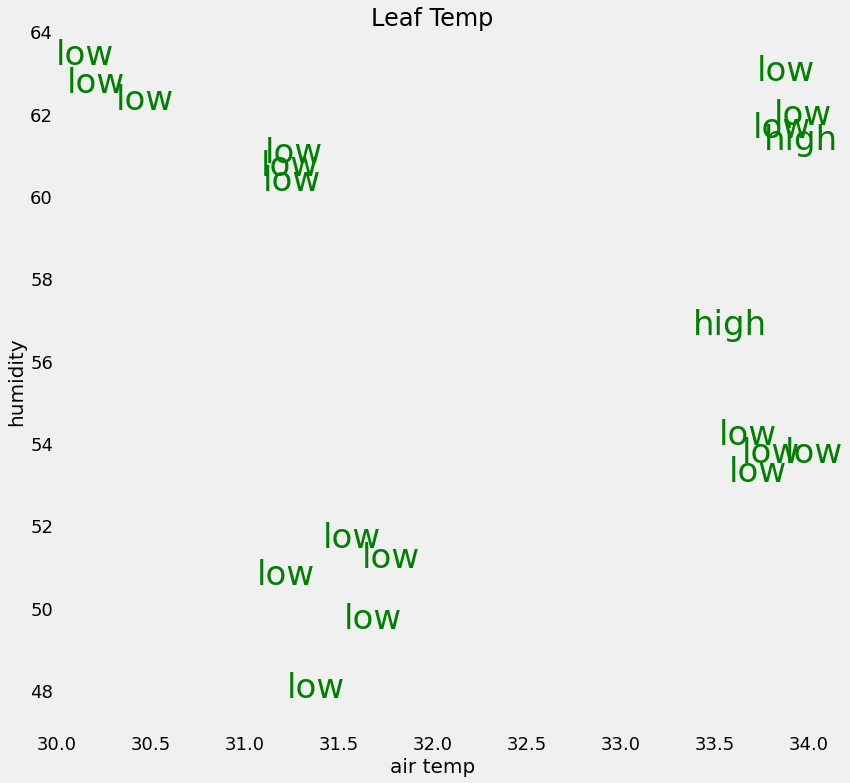

In [73]:
# Plot data?
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))

# Plot a subset each point as the label
for x1, x2, label in zip(X_1f[0:20, 0], X_1f[0:20, 1], yy.strlabel[0:20].values):
    plt.text(x1, x2, label, fontsize = 34, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((30, 34));
plt.ylim((47, 64));
plt.xlabel('air temp', size = 20); plt.ylabel('humidity', size = 20); plt.title('Leaf Temp', size = 24)

<div style="background-color: #ccffcc; padding: 10px;">
    
This shows a simple linear classifier will not be able to draw a boundary that separates the classes. The single decision tree will be able to completely separate the points because it essentially draws many repeated linear boundaries between points. A decision tree is a non-parametric model because the number of parameters grows with the size of the data.
    
</div>

# Decision Trees




<div style="background-color: #cce5ff; padding: 10px;">

Here we quickly build and train a single decision tree on the data using Scikit-Learn `sklearn.DecisionTreeClassifier`. The tree will learn how to separate the points, building a flowchart of questions based on the feature values and the labels. At each stage, the decision tree makes splits by maximizing the reduction in Gini impurity.

    
We'll use the default hyperparameters for the decision tree which means it can grow as deep as necessary in order to completely separate the classes. This will lead to overfitting because the model memorizes the training data, and in practice, we usually want to limit the depth of the tree so it can generalize to testing data..

</div>

In [ ]:
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)

In [99]:
# After runnning the follow cells try seeing the effect of limiting the max depth
tree = DecisionTreeClassifier(max_depth=4, random_state=RSEED)

In [100]:
tree.fit(X_1f, yy.label.values)

DecisionTreeClassifier(max_depth=4, random_state=50)

In [101]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(X_1f, yy.label.values )}')

Decision tree has 29 nodes with maximum depth 4.
Model Accuracy: 0.825


<div style="background-color: #ccffcc; padding: 10px;">

With out limitting the the depth of the tree the model will have achieved 100% accuracy 
    

## Visualizing the decision tree

To get a sense of how the decision tree "thinks", it's helpful to visualize the entire structure. This will show each node in the tree which we can use to make new predictions. Because the tree is relatively small, we can understand the entire image.

</div>
<div style="background-color: #cce5ff; padding: 10px;">
We can use `graphviz` to visualise and limit the depth so the tree isn't too large to display 

**Note graphviz dependency doens't always work out the box so will load example image if this fails**
    </div>

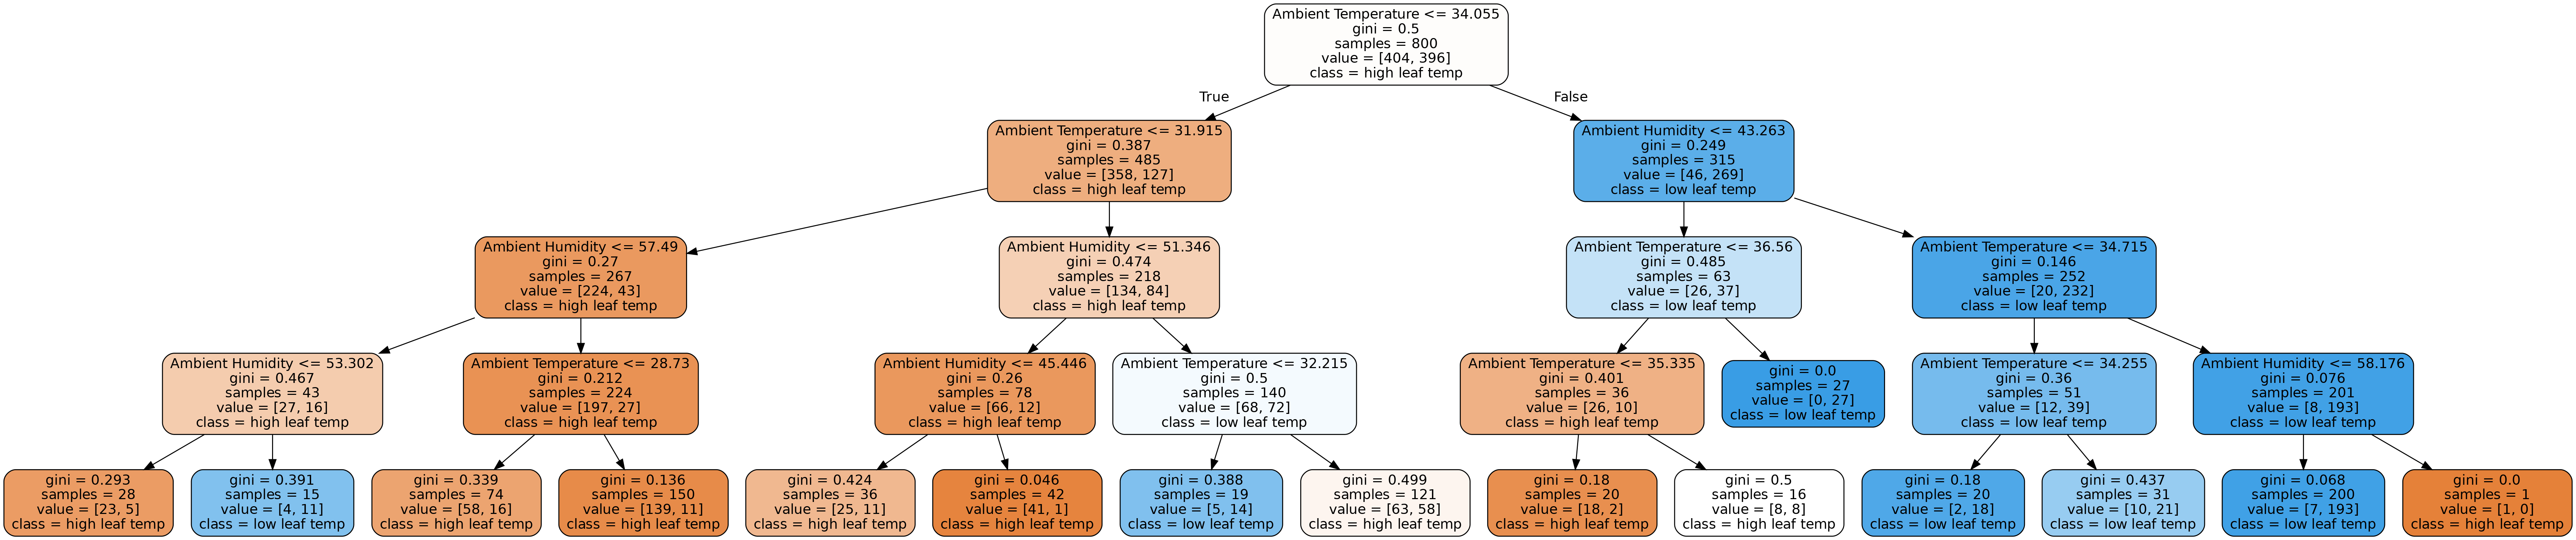

In [102]:
# Save tree as dot file
export_graphviz(tree, 'tree_example.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['high leaf temp', 'low leaf temp'], filled = True)

# Convert to png
try:
    call(['dot', '-Tpng', 'tree_example.dot', '-o', 'tree_example.png', '-Gdpi=200'])
except:
    print('graphviz ')

    
Image(filename='tree_example.png')

<div style="background-color: #ccffcc; padding: 10px;">
    
At each node the decision tree considers a feature based question reducing the Gini impurity


### Gini Impurity 

The probability  that a randomly selected sample from a node will be incorrectly classified according to the distribution of samples in a node. At each split the tree tries to pick values that reduce the gini impurity, here we get to 0 for every training point as no limit was set (full tree not shown here)


<hr>

</div>

In [103]:
# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(X_1f,yy.label.values , 
                                                          stratify = yy.label.values,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [104]:
# Features for feature importances
features = ['Ambient Temperature','Ambient Humidity']


In [105]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 29 nodes with maximum depth 4.


In [106]:
# Will over fit
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [107]:
print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.8958745264124708
Test ROC AUC  Score: 0.8132856448364472


<div style="background-color: #ccffcc; padding: 10px;">
    
# Evaluating the mode

[Receiver Operating Characteristic (ROC) curves](https://medium.com/cascade-bio-blog/making-sense-of-real-world-data-roc-curves-and-when-to-use-them-90a17e6d1db) describe the trade-off between the true positive rate (TPR) and false positive (FPR) rate along different probability thresholds for a classifier. 

</div>

Recall Baseline: 1.0 Test: 0.67 Train: 0.74
Precision Baseline: 0.5 Test: 0.83 Train: 0.93
Roc Baseline: 0.5 Test: 0.81 Train: 0.9


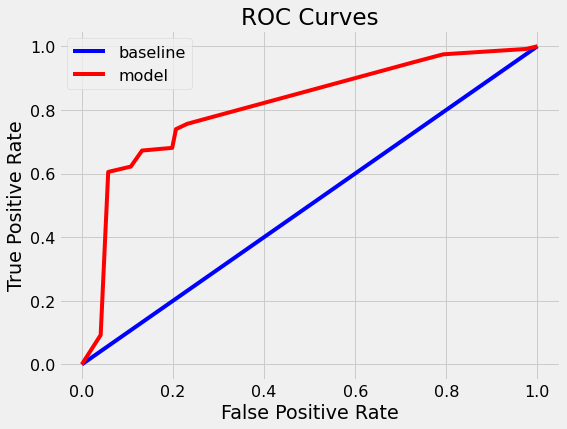

In [108]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
evaluate_model(predictions, probs, train_predictions, train_probs)

<div style="background-color: #ccffcc; padding: 10px;">

If the model line is to the left of the blue it is performing better than random chance     
    
</div>
<div style="background-color: #ccffcc; padding: 10px;">
    
## Feature Importances

We can extract the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used, below shows the realive imporantance assigned to Abient Temperature vs Ambient humidity

</div>

In [110]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()



,feature,importance
0,Ambient Temperature,0.811606
1,Ambient Humidity,0.188394


In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[105  16]
 [ 39  80]]


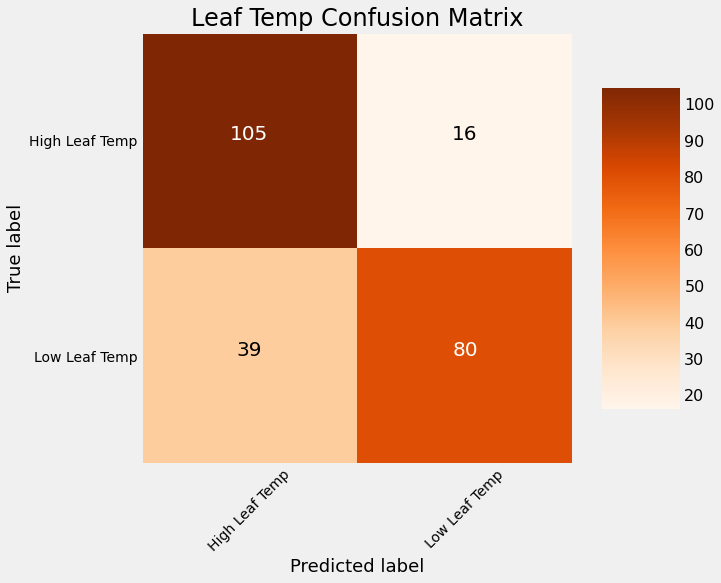

In [111]:


cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['High Leaf Temp', 'Low Leaf Temp'],
                      title = 'Leaf Temp Confusion Matrix')



<div style="background-color: #e6ccff; padding: 10px;">
    
Limit Maximum Depth

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

</div>
<div style="background-color: #cce5ff; padding: 10px;">
    
**Try going back and uncommenting the line:** `tree = DecisionTreeClassifier(max_depth=4, random_state=RSEED)`
**and re-running the rest of the following cells untill this one**
</div>
<div style="background-color: #e6ccff; padding: 10px;">
The model no longer gets perfect accuracy on the training data. However, it probably would do better on the testing data since we have limited the maximum depth to prevent overfitting. This is an example of the bias - variance tradeoff in machine learning. A model with high variance has learned the training data very well but often cannot generalize to new points in the test set. On the other hand, a model with high bias has not learned the training data very well because it does not have enough complexity. This model will also not perform well on new points.

Limiting the depth of a single decision tree is one way we can try to make a less biased model. Another option is to use an entire forest of trees, training each one on a random subsample of the training data. The final model then takes an average of all the individual decision trees to arrive at a classification. This is the idea behind the random forest.

</div>


# Random Forests

<div style="background-color: #ccffcc; padding: 10px;">
    
An ensemble (1000 or 100,000 s) of decision trees, training each tree on a random set of observations and for each node only a subset of features are used and the predictions are averaged to arrive at he final classifciation

</div>

<div style="background-color: #cce5ff; padding: 10px;">
`RandomForestRegressor(max_features, random_state=SEED, n_estimators , max_depth)`
</div>

# Random Forest Hyperparameters 

<div style="background-color: #e6ccff; padding: 10px;">

* **Max features :** The number of features to consider when looking for the best split. This could be set to N/3 as a quick heuristic for regression (rounding up).

* **Max samples:** The proportion of the data set used for bootstrapping. The default is set to using the whole data set for bootstrapping, and is usually a sensible way to go.

* **Number of Trees:** The number of trees grown in the forest. In general, more trees will result in better performance, which eventually plateaus. Over-fitting is not a danger here.

* **Max depth:** The depth of a decision tree. The default is to keep trees unpruned.



# [K-fold cross validation](https://towardsdatascience.com/k-fold-cross-validation-explained-in-plain-english-659e33c0bc0)

<img src="images/kfold.png">

1. Split the data into k folds 
2. Reserve 1 fold for testing and use the remaining n-1 folds for training 
3. Repeat the procedure over all k folds
4. Average performance evaluation statistics across folds. 

</div>

<div style="background-color: #cce5ff; padding: 10px;">
In this piece of work I use 10 Folds and repeat the whole process 3 times.

`RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)`
</div>



<div style="background-color: #e6ccff; padding: 10px;">


# Evaluating the Random Forest 

* [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination) : proportion of variance explained by the model 

* [RMSE](https://en.wikipedia.org/wiki/Mean_squared_error): standard deviation of the prediction errors (residuals)
    
</div>

In [112]:
#%% conduct sensitivity test on max depth

# seed 
SEED = 1

# range of tree depths
mds = np.arange(1,30)

# list for evaluation
r2_sens_lst_md = []
rmse_sens_lst_md = []

# loop over all values for maximum depth between 1 and 30, storing the r2 and rmse for 10 fold cross validation
for i in range(len(mds)):
    md = mds[i]
    rf_sens = RandomForestRegressor(max_features = 3, random_state=SEED, n_estimators = 100, max_depth = md)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    r2s_sens = list(cross_val_score(rf_sens, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
    rmses_sens = list(cross_val_score(rf_sens, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))
    r2_sens = statistics.mean(r2s_sens)
    rmse_sens = statistics.mean(rmses_sens)
    r2_sens_lst_md.append(r2_sens)
    rmse_sens_lst_md.append(rmse_sens)

In [15]:
# max depth dataframe 
df_sens_md = pd.DataFrame({'max_depth' : list(mds), 'r2' : r2_sens_lst_md, 'rmse' : rmse_sens_lst_md})
df_sens_md['rmse'] = df_sens_md['rmse']*-1

Text(0.5, 1.0, 'max features vs. r2')

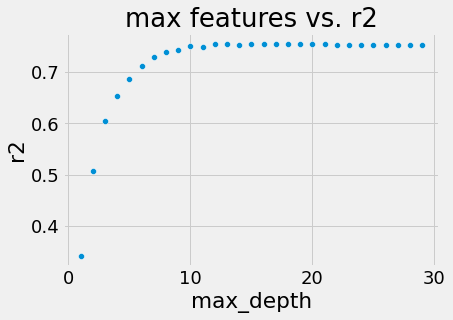

In [16]:
# scatterplot for maximum depth vs.performance metric (change 'r2' for 'rmse' to replicate the plots in the presentation)
sns.scatterplot(x = 'max_depth', y = 'r2', data = df_sens_md)
plt.title('max features vs. r2')

<div style="background-color: #ccffcc; padding: 10px;">

# Sensitivity testing

Sensitivity Testing for Maximum Depth 
Past a maximum tree depth of approx. 25, there is no change to either the variance explained or the bias.
For this reason, it is useful to prune the depth of the random forest to this value to save computation time.

</div>

In [17]:
#%% conduct sensitivity test on number of parameters to split

# range of parameters
mxf = np.arange(1,9)

# list for evaluation
r2_sens_lst_mxf = []
rmse_sens_lst_mxf = []

# loop over all values for maximum number of features used in splitting between 1 and 9, storing the r2 and rmse for 10 fold cross validation
for i in range(len(mxf)):
    mx = mxf[i]
    rf_sens = RandomForestRegressor(max_features = mx, random_state=SEED, n_estimators = 100)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    r2s_sens = list(cross_val_score(rf_sens, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
    rmses_sens = list(cross_val_score(rf_sens, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))
    r2_sens = statistics.mean(r2s_sens)
    rmse_sens = statistics.mean(rmses_sens)
    r2_sens_lst_mxf.append(r2_sens)
    rmse_sens_lst_mxf.append(rmse_sens)

# max depth dataframe 
df_sens_mxf = pd.DataFrame({'max_features' : list(mxf), 'r2' : r2_sens_lst_mxf, 'rmse' : rmse_sens_lst_mxf})
df_sens_mxf['rmse'] = df_sens_mxf['rmse']*-1

Text(0.5, 1.0, 'max features vs. r2')

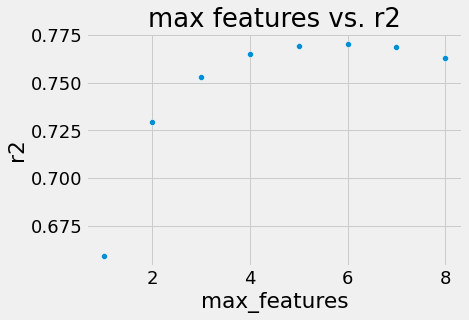

In [18]:
# scatterplot for maximum number of features vs.performance metric (change 'r2' for 'rmse' to replicate the plots in the presentation)
sns.scatterplot(x = 'max_features', y = 'r2', data = df_sens_mxf)
plt.title('max features vs. r2')

<div style="background-color: #ccffcc; padding: 10px;">
    
Sensitivity Testing for Maximum Features in Splits

Past a maximum features of 5, there is very little increase in variance explained or improvement in model bias. Therefore Max features of 5 is selected. 
</div>

In [19]:
#%% Evaluate the performance of the Random Forest Algorithm with chosen parameters from the sensitivity analysis using cross validation 

# instantiate the random forest regressor
rf = RandomForestRegressor(max_features = 5, random_state=SEED, n_estimators = 100, max_depth = 25)

In [20]:
# set up the cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [21]:
# calculate the metrics for each kfold cross validation
r2s = list(cross_val_score(rf, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
rmses = list(cross_val_score(rf, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))

# take the mean of these 
r2 = statistics.mean(r2s)
rmse = statistics.mean(rmses)

<div style="background-color: #ccffcc; padding: 10px;">

# Predictive ability 
    
 The model is able to explain a useful share of variance explained (mean = 0.77) with a reasonably low bias  (mean = 1.50)

This suggests that expanded versions of this model may be a useful sub-module in land surface / crop growth models.


# Feature importance

Clearly Ambient Temperature and Ambient Humidity are the most important features for prediction. However, features like photosynthetic efficiency, membrane conductance and relative chlorophyll also contributed. Their importance was a lot greater than a column of random numbers. Many of these quantities are available from satellites, so this kind of model may be applicable across spatial scales.
    
<div style="background-color: #ccffcc; padding: 10px;">


In [262]:
#%% calculate the feature importances 

# fit the random forest regressor with the dataframe of predictor variables that includes the column of random numbers for comparison
rf.fit(X_features, y)

# feature importances
importance = rf.feature_importances_

# features
features = list(X_features.columns)

# dataframe for plotting 
df_features = pd.DataFrame(list(zip(importance, features)), 
               columns =['importance', 'features'])

NameError: name 'rf' is not defined

<AxesSubplot:xlabel='importance', ylabel='features'>

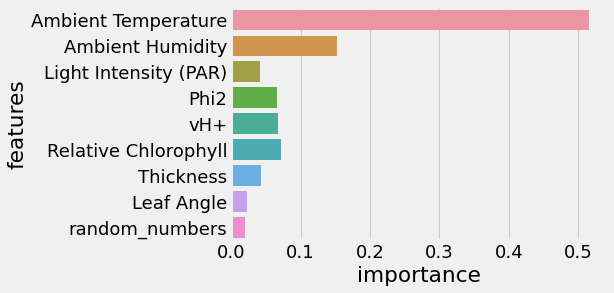

In [23]:
#%% plot the feature importances

sns.barplot(x = 'importance', y = 'features', data = df_features)

In [24]:
#%% compose the statistics for each cross validation effort in a dataframe for plotting.

df_eval = pd.DataFrame({'r2' : r2s, 'rmse' : rmses})
df_eval['rmse'] = df_eval['rmse']*-1

Text(0.5, 1.0, '10 fold cross validation repeated 3 times')

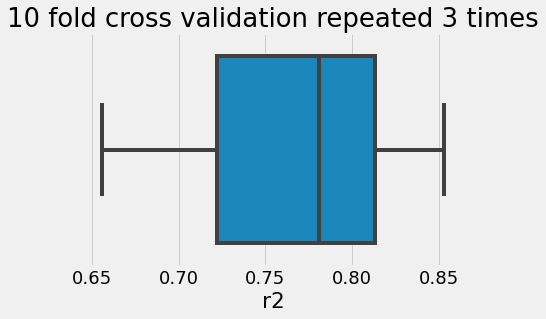

In [25]:
#%% plot the statistics

# replace r2 with rmse to reproduce the plots in the presentation
sns.boxplot(x ='r2', data = df_eval)
plt.title('10 fold cross validation repeated 3 times')

# Using Automated Hyperparamter Selection

<div style="background-color: #cce5ff; padding: 10px;">

We can use `RandomizedSearchCV` so search a parameter grid to search for what hyparameters will create the best perfroming model
    
* increasing `n_iter` may increase performace but will be slower to run
* `cv = 10` is a 10 fold cross validation
* `scoring = 'r2'` scores based on r squared   

</div>

In [254]:
# Estimator for use in random search
estimator = RandomForestRegressor( random_state=SEED)

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}




# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'r2', cv = 10, 
                        n_iter = 50, verbose = 1, random_state=RSEED)

In [255]:
# Fit 
rs.fit(train, train_labels)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                           

In [256]:
# Took several mins 
# Now we can access the best hyper parameteres
rs.best_params_

{'n_estimators': 137,
 'min_samples_split': 10,
 'max_leaf_nodes': 32,
 'max_features': 0.6,
 'max_depth': 5,
 'bootstrap': False}

This produces slightly different hyperparameters that our sensitivity testing

In [257]:
best_model = rs.best_estimator_
# calculate the metrics for each kfold cross validation
r2s = list(cross_val_score(best_model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise'))
rmses = list(cross_val_score(best_model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise'))

# take the mean of these 
r2 = statistics.mean(r2s)
rmse = statistics.mean(rmses)

In [258]:
#%% calculate the feature importances 

# fit the random forest regressor with the dataframe of predictor variables that includes the column of random numbers for comparison
best_model.fit(X_features, y)

# feature importances
importance = best_model.feature_importances_

# features
features = list(X_features.columns)

# dataframe for plotting 
df_features = pd.DataFrame(list(zip(importance, features)), 
               columns =['importance', 'features'])

<AxesSubplot:xlabel='importance', ylabel='features'>

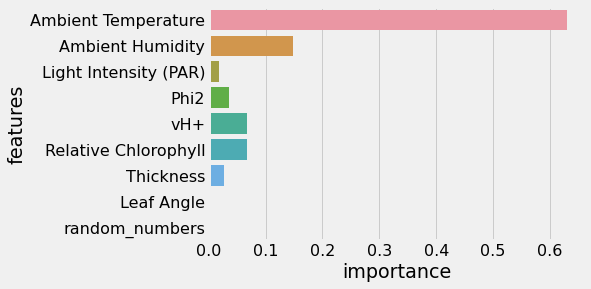

In [259]:
#%% plot the feature importances

sns.barplot(x = 'importance', y = 'features', data = df_features)

<div style="background-color: #ccffcc; padding: 10px;">

The best model selected here uses less features but the broad pattern remains the same

</div>

In [260]:
#%% compose the statistics for each cross validation effort in a dataframe for plotting.

df_eval = pd.DataFrame({'r2' : r2s, 'rmse' : rmses})
df_eval['rmse'] = df_eval['rmse']*-1

Text(0.5, 1.0, '10 fold cross validation repeated 3 times')

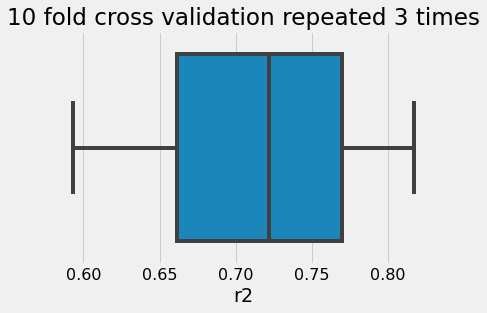

In [261]:
#%% plot the statistics

# replace r2 with rmse to reproduce the plots in the presentation
sns.boxplot(x ='r2', data = df_eval)
plt.title('10 fold cross validation repeated 3 times')

<div style="background-color: #ccffcc; padding: 10px;">

The best model here performs slightly worse than our sensitivy testing hyperparameter selection. 
</div>